# Generating Shakespeare word by word

This is a small example of a GPT that is trained on Shakespeare text. This notebook has major inspiration from https://github.com/karpathy/nanoGPT. It's great to get familiar and play around with GPT alwhile not necessarly having a cluster of 1000s of GPUs.

This notebook is conceptually the same as `shakespeare_char.ipynb` but instead of predicting a character, the model will predict a word. We don't use any fancy tokenizer here but use classic regex to split the Shakspeare text into words (you can see that `data/shakespeare_word/prepare.py` changes slightly from `data/shakespeare_char/prepare.py`). The regex could be largely improved since words are case sensitive, etc...

In [1]:
import os 
import re
import torch
import pickle
import matplotlib.pyplot as plt

from misc import get_batch
from model.gpt2 import GPT2
from trainer.gpt_trainer import GPTTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We launch the `data/shakespeare_word/prepare.py` file in order to have our data setup.

In [2]:
! python data/shakespeare_word/prepare.py 

the first 100 unique word tokens are: 3|A|ABHORSON|ABRAHAM|ADRIAN|AEacides|AEdile|AEdiles|AEneas|AEsop|ALL|ALONSO|ANGELO|ANNE|ANOTHER|ANTIGONUS|ANTONIO|ARCHBISHOP|ARCHIDAMUS|ARIEL|AUFIDIUS|AUMERLE|AUTOLYCUS|Abase|Abate|Abated|Abbot|Abel|Abhorred|Abhorson|Abides|Able|About|Above|Abraham|Absolute|Accept|Accomplish|According|Accords|Account|Accountant|Accursed|Accuse|Achieve|Acquaint|Action|Adam|Add|Added|Adding|Address|Adieu|Adjudged|Admit|Adonis|Adoptedly|Adopts|Adrian|Adriatic|Advance|Advantaging|Adversity|Advertising|Advocate|Affection|Affliction|Affrighted|Affrights|Affront|Afore|Afresh|Afric|African|After|Again|Against|Agamemnon|Age|Aged|Agenor|Agreed|Agrippa|Ah|Aim|Aiming|Airy|Ajax|Al|Alack|Alas|Alban|Albeit|Albion|Alcides|Alexander|Alike|Alive|All|Alla
vocab size: 13,321
train has 187,677 tokens
val has 20,853 tokens


In this dataset we have 13,331 unique words (tokens) that form our vocabulary size, 236k tokens for training and 26k for validation.

In [3]:
data_dir = "data/shakespeare_word/"
meta_path = os.path.join(data_dir, 'meta.pkl')
vocab_size = None

if os.path.exists(meta_path):
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    vocab_size = meta['vocab_size']
    itow = meta['itow']
    stow = meta['stow']
    print(f"found vocab_size = {vocab_size} (inside {meta_path})")

found vocab_size = 13321 (inside data/shakespeare_word/meta.pkl)


We then get some meta data and other convienences. For example, the GPT trained hereafter will have the task of predicting the next Shakesperian character given its context. Autoregressively, you can generate many characters that will eventually form sentences and paragraphs.

The function `encode` and `decode` will help to convert the produced GPT output into readable characters. We also provide an example of how a `str` is encoded for the model and how the model's output `array` of `int` are decoded to produce Shaspearian litterature.

In [4]:
def encode(s):
    pattern = r'\b\w+\b|[^\w\s]'
    # Find all words
    data = re.findall(pattern, s)
    return torch.tensor([stow[c] for c in data])

decode = lambda l: ' '.join([itow[i] for i in l])

shakspeare_lines = "the king will"
x = encode(shakspeare_lines)
print("The text '{}' is encoded and fed to the GPT as {}".format(shakspeare_lines, x))
y = decode(x.tolist())
assert shakspeare_lines == y

The text 'the king will' is encoded and fed to the GPT as tensor([11963,  7805, 13098])


We choose to use the same hyperparameters from https://github.com/karpathy/nanoGPT for a small example of CPU. 

In [5]:
block_size = 64
n_layer, n_head, n_embd, dropout = 4, 4, 128, 0.0

model = GPT2(vocab_size, block_size, n_embd, n_head, n_layer)
model = model.to(device)
print("GPT number of parameters:", sum(p.numel() for p in model.parameters()))

GPT number of parameters: 4220681


We instantiate also our `GPTTrainer` code from `trainer/gpt_trainer.py`. 

In [6]:
trainer = GPTTrainer(model, lr=5e-4, checkpoint_path="metadata/shakespeare_word/")

True
Created checkpoint directory at metadata/shakespeare_word/


We call the `train` method from our `trainer` that takes as input : 
- `get_batch`: a function that fetches batches of data
- `max_iters`: number of max iterations
- `batch_size`: batch size 
- `patience`: an argument that essentially stops the training if the validation loss hasn't improve in `#patience` optimization steps. 
- `save_every`: that saves the model weights and other things at `save_every` multiples of iteration step. 

In [7]:
partial_get_batch = lambda split, batch_size: get_batch(data_dir, split, batch_size, device, block_size)
trainer.train(partial_get_batch, max_iters=2000, batch_size=64, patience=2000, save_every=30)

Iter :1999/2000 Train Loss 3.598e+00 / Eval Loss 8.992e+00: 100%|██████████| 2000/2000 [13:15<00:00,  2.51it/s]


Lets see the loss curve from this training and also generate some text ! We also added a `temperature` and `top_k` hyperparameters to give a bit more flexibility to the generation. We see here that the GPT model overfits fast, something that can be amended by using more data and a larger model (our model here is 4M, GPT2 was 124M)

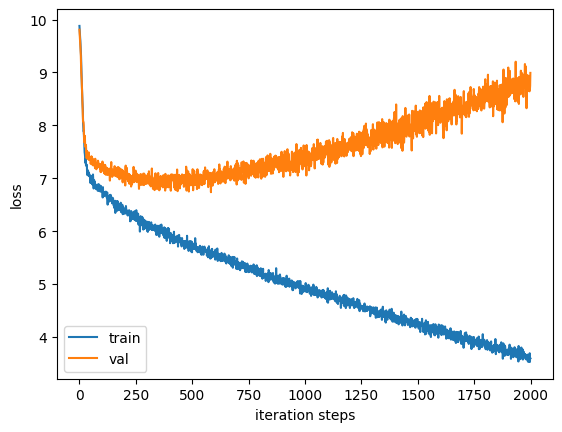

In [8]:
plt.plot(trainer.losses, label='train')
plt.plot(trainer.val_losses, label='val')
plt.xlabel('iteration steps')
plt.ylabel('loss')
plt.legend()

What we see here is that the Tokenizer doesn't keep the structure of Shakespeare, something that is expected.

In [9]:
model.eval()
x = encode("QUEEN MARGARET \n")
x = x.view(1, -1).to(device)
y = model.generate(x, 256, temperature=1.0, top_k=None)
decoded_y = decode(y[0].tolist())
split_decode_y = decoded_y.split(" ")
for i in range(0, len(split_decode_y), 10):
    print(" ".join(split_decode_y[i:i+10]))


100%|██████████| 256/256 [00:00<00:00, 311.38it/s]


QUEEN MARGARET Come go by me our princely souls for
you all the strength of promise you Thus are to
us BLUNT So let their queen I denied with RIVERS
Have they put your honour by your hate Let me
twine This is my very services marry join and ye
re Be taken sanctuary in that instruct her present hearts
As much is POLIXENES You are transported and ours HORTENSIO
Her lover had to the gentleman for him any man
Why how found t and quietness I thank you must
thus well POLIXENES Those offer service tis yours That we
have you deserved it on for that more man prithee
have met d with child Than vow He says My
lord pluck d for a brave o the wounds their
tides you break her bear I am ended with Volscians
talk d Your purse to weed and are dried out
to choose The injury The wanton Edward s fruit KING
RICHARD III Because our friends at least we will hear
it do cry the present thee do Keeper Give me
a gross at once The guilt of our seemers was
done usurp deposed KING RICHARD II O general Fear not
mind 

# Using a better Tokenizer

The result of the training above aren't great, this is in part due to the tokenizer. 

OpenAI's has a GTP2 tokenizer package that does all the heavylifting for you :`tiktoken` (https://github.com/openai/tiktoken). Let's redo the whole training with this new tokenizer ! 

In [10]:
! pip install tiktoken
import tiktoken

Here's is also a quick example of how the tokenizer works.

In [11]:
# Let's use the gpt2 tokenizer encoding 
enc = tiktoken.get_encoding("r50k_base")
vocab_size = enc.n_vocab
print("The vocab size of the tokenizer is", vocab_size)

# Similarly to the encode and decode functions defined above, the encoding object has encode and decode methods.
shakspeare_lines = "the king will"
x = enc.encode(shakspeare_lines)
print("The text '{}' is encoded by OpenAI's tokenizer and fed to the GPT2 as {}".format(shakspeare_lines, x))
assert enc.decode(x) == shakspeare_lines

The vocab size of the tokenizer is 50257
The text 'the king will' is encoded by OpenAI's tokenizer and fed to the GPT2 as [1169, 5822, 481]


Since the tokenizer is different, we also need to generate the data again. We will use the same Shakespeare dataset, but we will use the new tokenizer to encode the data.

In [12]:
! python data/shakespeare_word/prepare.py --openai_gpt2_tokenizer=1

train has 304,222 tokens
val has 33,803 tokens


In [39]:
block_size = 64
n_layer, n_head, n_embd, dropout = 4, 4, 128, 0.0

model = GPT2(vocab_size, block_size, n_embd, n_head, n_layer)
model = model.to(device)
print("GPT number of parameters:", sum(p.numel() for p in model.parameters()))

GPT number of parameters: 13713233


With this new tokenizer, since the `vocab_size` is larger we also have a larger model (14M params) ! We now instantiate our trainer and launch the training.

In [47]:
from trainer.gpt_trainer import GPTTrainer
trainer = GPTTrainer(model, lr=5e-4, checkpoint_path="metadata/shakespeare_word_openai_tokenizer/")

True
Created checkpoint directory at metadata/shakespeare_word_openai_tokenizer/


In [48]:
partial_get_batch = lambda split, batch_size: get_batch(data_dir, split, batch_size, device, block_size, openai_gpt2_tokenizer=True)
trainer.train(partial_get_batch, max_iters=2000, batch_size=32, patience=2000, save_every=30)

Iter :1999/2000 Train Loss 3.406e+00 / Eval Loss 4.992e+00: 100%|██████████| 2000/2000 [40:40<00:00,  1.22s/it]


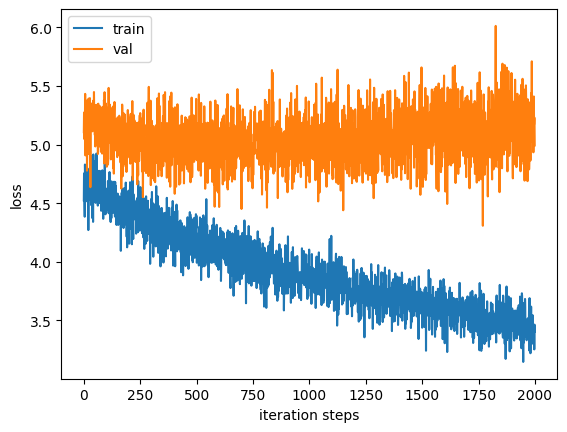

In [51]:
plt.plot(trainer.losses, label='train')
plt.plot(trainer.val_losses, label='val')
plt.xlabel('iteration steps')
plt.ylabel('loss')
plt.legend()

We see here that the Tokenizer and the training together does have better formatting of Shakespeare style text. In terms of generation its still hard to tell. What we know from LLMs is that after a certain size, they start to perform really well ! Lets try to push by training even more, but we will need to use several GPUs for that.

In [52]:
model.eval()
x = torch.tensor(enc.encode("QUEEN MARGARET \n"))
x = x.view(1, -1).to(device)
y = model.generate(x, 2*64, temperature=1.0, top_k=None)
decoded_y = enc.decode(y[0].tolist())
print(decoded_y)

100%|██████████| 128/128 [00:00<00:00, 138.36it/s]

QUEEN MARGARET 
Thou cannot live home but by thy oath
Is some sparks for a plats; they are a match,
Abbotly Baptista Minola. O what thou hast
Shall I been enough on Stanley?

GREEN:
That she is three thousand thanks, to weep then,
Which can make no longer stay with her deeds.

ROMEO:
But that, say 'neven, bear says too cold abroad.

Servant:
Be too; they stay now awake to shun abroad.

GRUMNIA:
Can I are to Rome; I think to have any


# Using multiple GPUs to scale your GPT model

We will use Pytorch's DistributedDataParallel (https://pytorch.org/tutorials/intermediate/ddp_tutorial.html) to train, our GPT model with several GPUs. 

Please note that the model itself will be larger but not that big ; using FSDP (https://pytorch.org/tutorials/intermediate/FSDP_tutorial.html) would be overkill here !